<a href="https://colab.research.google.com/github/ashayghiya/Hackathons/blob/master/News_Category_Machine_Hack_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preprocessing

In [0]:
import gensim
from gensim import corpora, models
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
# Others
import re
import nltk
import string
import numpy as np
import pandas as pd

from sklearn.manifold import TSNE
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

np.random.seed(2019)

# Disable Warnings
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
df = pd.read_excel(r'Data_Train.xlsx')
df.head()

,STORY,SECTION
0,But the most painful was the huge reversal in ...,3
1,How formidable is the opposition alliance amon...,0
2,Most Asian currencies were trading lower today...,3
3,"If you want to answer any question, click on ‘...",1
4,"In global markets, gold prices edged up today ...",3


In [0]:
df['SECTION'].value_counts()

1    2772
2    1924
0    1686
3    1246
Name: SECTION, dtype: int64

In [0]:
num_words = [len(s.split()) for s in df['STORY']]
print(r'number of words per sample: {}'.format(np.mean(num_words)))
print(r'number of samples: {}'.format(len(num_words)))
print(r'ratio: {}'.format(len(num_words)/np.mean(num_words)))

number of words per sample: 107.58927635028842
number of samples: 7628
ratio: 70.89925928272638


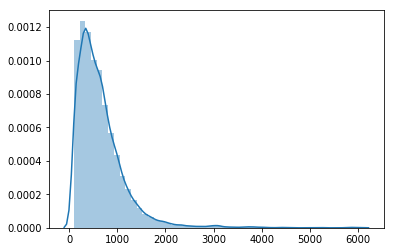

In [0]:
sns.distplot([len(s) for s in df['STORY']])

In [0]:
y = pd.get_dummies(df['SECTION'])
y.head()

,0,1,2,3
0,0,0,0,1
1,1,0,0,0
2,0,0,0,1
3,0,1,0,0
4,0,0,0,1


In [0]:
def clean_text(text):
    
    ## Remove puncuation
    text = text.translate(string.punctuation)
    
    ## Convert words to lower case and split them
    text = text.lower().split()
    
    ## Remove stop words
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops and len(w) >= 3]
    
    text = " ".join(text)
    ## Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)
    ## Stemming
    text = text.split()
    stemmer = SnowballStemmer('english')
    stemmed_words = [stemmer.stem(word) for word in text]
    text = " ".join(stemmed_words)
    return text

In [0]:
df['text'] = df['STORY'].map(lambda x: clean_text(x))

In [0]:
df['text'][0]

'pain huge revers fee incom unheard among privat sector lender essenti mean yes bank took grant fee structur loan deal paid account upfront book borrow turn default fee tie loan deal fell crack gill vow shift safer account practic amort fee incom rather book upfront + + + gill s move mend past way mean nasti surpris futur good news consid investor love clean imag loath uncertainti + + + but gain without pain promis strong stabl balanc sheet come sacrific well investor give hope phenomen growth promis made kapoor'

# Training

In [0]:
import tensorflow as tf
from tensorflow.python.keras import models
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Dropout
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

In [0]:
X_train, X_test, y_train, y_test = train_test_split(df['text'].values, df['SECTION'].values,
                                                    test_size = 0.2, random_state = 100)

In [0]:
from tensorflow.python.keras.preprocessing import sequence
from tensorflow.python.keras.preprocessing import text

# Vectorization parameters
# Limit on the number of features. We use the top 20K features.
TOP_K = 20000

# Limit on the length of text sequences. Sequences longer than this
# will be truncated.
MAX_SEQUENCE_LENGTH = 500

def sequence_vectorize(train_texts, val_texts):
    """Vectorizes texts as sequence vectors.

    1 text = 1 sequence vector with fixed length.

    # Arguments
        train_texts: list, training text strings.
        val_texts: list, validation text strings.

    # Returns
        x_train, x_val, word_index: vectorized training and validation
            texts and word index dictionary.
    """
    # Create vocabulary with training texts.
    tokenizer = text.Tokenizer(num_words=TOP_K)
    tokenizer.fit_on_texts(train_texts)

    # Vectorize training and validation texts.
    x_train = tokenizer.texts_to_sequences(train_texts)
    x_val = tokenizer.texts_to_sequences(val_texts)

    # Get max sequence length.
    max_length = len(max(x_train, key=len))
    if max_length > MAX_SEQUENCE_LENGTH:
        max_length = MAX_SEQUENCE_LENGTH

    # Fix sequence length to max value. Sequences shorter than the length are
    # padded in the beginning and sequences longer are truncated
    # at the beginning.
    x_train = sequence.pad_sequences(x_train, maxlen=max_length)
    x_val = sequence.pad_sequences(x_val, maxlen=max_length)
    return x_train, x_val, tokenizer, max_length

In [0]:
x_train, x_val, tokenizer, max_length = sequence_vectorize(X_train, X_test)
train_labels = y_train
val_labels = y_test 

units = 4
activation = 'softmax'
num_classes = 4

In [0]:
from tensorflow.python.keras import models
from tensorflow.python.keras import initializers
from tensorflow.python.keras import regularizers

from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Dropout
from tensorflow.python.keras.layers import Embedding
from tensorflow.python.keras.layers import SeparableConv1D
from tensorflow.python.keras.layers import MaxPooling1D
from tensorflow.python.keras.layers import GlobalAveragePooling1D

def sepcnn_model(blocks,
                 filters,
                 kernel_size,
                 embedding_dim,
                 dropout_rate,
                 pool_size,
                 input_shape,
                 num_classes,
                 num_features,
                 use_pretrained_embedding=False,
                 is_embedding_trainable=False,
                 embedding_matrix=None):
    """Creates an instance of a separable CNN model.

    # Arguments
        blocks: int, number of pairs of sepCNN and pooling blocks in the model.
        filters: int, output dimension of the layers.
        kernel_size: int, length of the convolution window.
        embedding_dim: int, dimension of the embedding vectors.
        dropout_rate: float, percentage of input to drop at Dropout layers.
        pool_size: int, factor by which to downscale input at MaxPooling layer.
        input_shape: tuple, shape of input to the model.
        num_classes: int, number of output classes.
        num_features: int, number of words (embedding input dimension).
        use_pretrained_embedding: bool, true if pre-trained embedding is on.
        is_embedding_trainable: bool, true if embedding layer is trainable.
        embedding_matrix: dict, dictionary with embedding coefficients.

    # Returns
        A sepCNN model instance.
    """
    op_units, op_activation = units, activation
    model = models.Sequential()

    # Add embedding layer. If pre-trained embedding is used add weights to the
    # embeddings layer and set trainable to input is_embedding_trainable flag.
    if use_pretrained_embedding:
        model.add(Embedding(input_dim=num_features,
                            output_dim=embedding_dim,
                            input_length=input_shape[0],
                            trainable=is_embedding_trainable))
    else:
        model.add(Embedding(input_dim=num_features,
                            output_dim=embedding_dim,
                            input_length=input_shape[0]))

    for _ in range(blocks-1):
        model.add(Dropout(rate=dropout_rate))
        model.add(SeparableConv1D(filters=filters,
                                  kernel_size=kernel_size,
                                  activation='relu',
                                  bias_initializer='random_uniform',
                                  depthwise_initializer='random_uniform',
                                  padding='same'))
        model.add(SeparableConv1D(filters=filters,
                                  kernel_size=kernel_size,
                                  activation='relu',
                                  bias_initializer='random_uniform',
                                  depthwise_initializer='random_uniform',
                                  padding='same'))
        model.add(MaxPooling1D(pool_size=pool_size))

    model.add(SeparableConv1D(filters=filters * 2,
                              kernel_size=kernel_size,
                              activation='relu',
                              bias_initializer='random_uniform',
                              depthwise_initializer='random_uniform',
                              padding='same'))
    model.add(SeparableConv1D(filters=filters * 2,
                              kernel_size=kernel_size,
                              activation='relu',
                              bias_initializer='random_uniform',
                              depthwise_initializer='random_uniform',
                              padding='same'))
    model.add(GlobalAveragePooling1D())
    model.add(Dropout(rate=dropout_rate))
    model.add(Dense(op_units, activation=op_activation))
    return model

In [0]:
def train_ngram_model(data,
                      learning_rate=1e-3,
                      epochs=1000,
                      batch_size=128,
                      blocks=4,
                      filters=64,
                      dropout_rate=0.2,
                      kernel_size=3,
                      embedding_dim=200,
                      pool_size=2):
    """Trains n-gram model on the given dataset.

    # Arguments
        data: tuples of training and test texts and labels.
        learning_rate: float, learning rate for training model.
        epochs: int, number of epochs.
        batch_size: int, number of samples per batch.
        blocks: int, number of blocks in the SepCNN model.
        units: int, output dimension of Dense layers in the model.
        dropout_rate: float: percentage of input to drop at Dropout layers.
        kernel_size: int, kernel size for sepCNN.
        embedding_dim: int, output of embedding vector.
        pool_size: int, size of the max pooling windows.

    # Raises
        ValueError: If validation data has label values which were not seen
            in the training data.
    """

    # Verify that validation labels are in the same range as training labels.
    unexpected_labels = [v for v in val_labels if v not in range(num_classes)]
    if len(unexpected_labels):
        raise ValueError('Unexpected label values found in the validation set:'
                         ' {unexpected_labels}. Please make sure that the '
                         'labels in the validation set are in the same range '
                         'as training labels.'.format(
                             unexpected_labels=unexpected_labels))


    # Create model instance.
    model = sepcnn_model(blocks=blocks,
                        filters=filters,
                        kernel_size=kernel_size,
                        embedding_dim=embedding_dim,
                        dropout_rate=dropout_rate,
                        pool_size=pool_size,
                        input_shape=data[0][0].shape[1:],
                        num_classes=num_classes,
                        num_features=max_length,
                        use_pretrained_embedding=True,
                        is_embedding_trainable=True)

    # Compile model with learning parameters.
    optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['acc'])

    # Create callback for early stopping on validation loss. If the loss does
    # not decrease in two consecutive tries, stop training.
    callbacks = [tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=2)]

    # Train and validate model.
    history = model.fit(
            x_train,
            train_labels,
            epochs=epochs,
            callbacks=callbacks,
            validation_data=(x_val, val_labels),
            verbose=2,  # Logs once per epoch.
            batch_size=batch_size)

    # Print results.
    history = history.history
    print('Validation accuracy: {acc}, loss: {loss}'.format(
            acc=history['val_acc'][-1], loss=history['val_loss'][-1]))

    return history['val_acc'][-1], history['val_loss'][-1], model

In [0]:
data = (x_train, train_labels), (x_val, val_labels)

In [0]:
max_length

500

In [0]:
train_ngram_model(data,
                learning_rate=1e-2,
                epochs=1000,
                batch_size=512,
                blocks=6,
                filters=64,
                dropout_rate=0.0,
                kernel_size=5,
                embedding_dim=50,
                pool_size=1)

Train on 6102 samples, validate on 1526 samples
Epoch 1/1000
6102/6102 - 11s - loss: 1.3558 - acc: 0.3448 - val_loss: 1.3376 - val_acc: 0.3748
Epoch 2/1000
6102/6102 - 9s - loss: 1.3497 - acc: 0.3605 - val_loss: 1.3367 - val_acc: 0.3748
Epoch 3/1000
6102/6102 - 9s - loss: 1.3479 - acc: 0.3605 - val_loss: 1.3369 - val_acc: 0.3748
Epoch 4/1000
6102/6102 - 9s - loss: 1.3475 - acc: 0.3605 - val_loss: 1.3373 - val_acc: 0.3748
Validation accuracy: 0.37483617663383484, loss: 1.3373163822906513


(0.37483618,
 1.3373163822906513,
 <tensorflow.python.keras.engine.sequential.Sequential at 0x7f1f0b710908>)

# Evaluation

In [0]:
from sklearn.metrics import classification_report
eval_list = [l.index(max(l)) for l in model.predict(x_val).tolist()]
print(classification_report(val_labels,eval_list))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97       332
           1       0.97      0.99      0.98       541
           2       0.99      0.98      0.98       382
           3       1.00      0.98      0.99       271

    accuracy                           0.98      1526
   macro avg       0.98      0.98      0.98      1526
weighted avg       0.98      0.98      0.98      1526



# Prediction

In [0]:
df1 = pd.read_excel(r'Data_Test.xlsx')
df1['text'] = df1['STORY'].map(lambda x: clean_text(x))
x_pred = vectorizer.transform(df1['text'].values)
x_pred = selector.transform(x_pred).astype('float32')

In [0]:
pred = model.predict(x_pred)
pred_list = pred.tolist()
pred_section = [l.index(max(l)) for l in pred_list]
df1['SECTION'] = pred_section
df1.head()

,STORY,text,SECTION
0,2019 will see gadgets like gaming smartphones ...,2019 see gadget like game smartphon wearabl me...,1
1,It has also unleashed a wave of changes in the...,also unleash wave chang mcu make sure futur lo...,2
2,It can be confusing to pick the right smartpho...,confus pick right smartphon yourself segreg to...,1
3,The mobile application is integrated with a da...,mobil applic integr dashboard confirm regist p...,1
4,We have rounded up some of the gadgets that sh...,round gadget show 2018 left indel mark on cons...,1


In [0]:
df1.to_excel(r'check_pred.xlsx')
df1['SECTION'].to_excel(r'submission.xlsx',index=False)